In [3]:
import libaarhusxyz
import numpy as np
import matplotlib.pyplot as plt
system = libaarhusxyz.parse_gex("2024_0627_110520.gex")
area = system['General']['TxLoopArea']
waveform_hm = system['General']['WaveformHMPoint']
waveform_lm = system['General']['WaveformLMPoint']
i_start_hm = int(system['Channel2']['RemoveInitialGates'])
i_start_lm = int(system['Channel1']['RemoveInitialGates'])
time_input_currents_hm = waveform_hm[:,0]
input_currents_hm = waveform_hm[:,1]
time_input_currents_lm = waveform_lm[:,0]
input_currents_lm = waveform_lm[:,1]
time_lm = system['General']['GateTimeLM'][:,0]
time_hm = system['General']['GateTimeHM'][:,0]

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed


The system noise level is around ~1e-9 V/m2

The peak moment of the system is :  80x80x30= 192000 A-m2
 
Please Note:  for simulation purpose,

- system noise level is assumed here 1ms
- it also assumes a certain stack size (depending on stationary or moving platform)
- Also we apply Tapered gating scheme to generate final gated signal, which reduces noise level by another factor of 2

In [4]:
# !pip install libaarhusxyz

In [5]:
times = time_hm[:16]

In [6]:
area = 80*80
radius = np.sqrt(area/np.pi)

In [8]:
system['Channel1']

{'TransmitterMoment': 'LM',
 'RxCoilNumber': 1.0,
 'GateTimeShift': 0.0,
 'GateFactor': 1.0,
 'RemoveInitialGates': 0.0,
 'PrimaryFieldDampingFactor': 1.0,
 'UniformDataSTD': 0.03,
 'NoGates': 27.0,
 'RepFreq': 50.0,
 'FrontGateTime': 0.0,
 'TiBLowPassFilter': array([1.e+00, 8.e+05]),
 'TxApproximateCurrent': 18.0,
 'SystemResponseConvolution': 0.0,
 'ReceiverPolarizationXYZ': 'Z',
 'ApproxDipoleMoment': 115200.0}

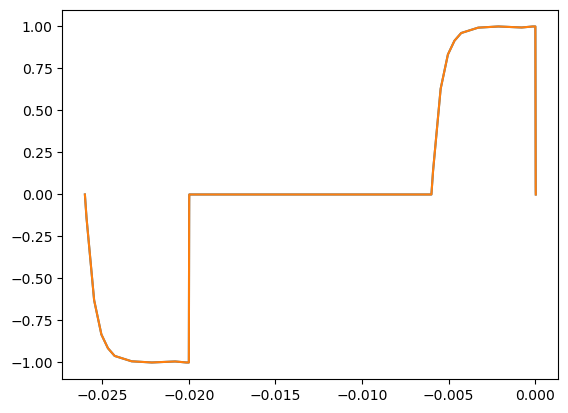

In [9]:
plt.plot(time_input_currents_hm, input_currents_hm)
plt.plot(time_input_currents_lm, input_currents_lm)

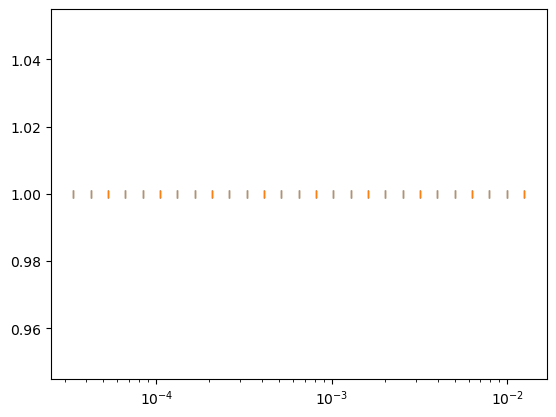

In [10]:
plt.semilogx(time_lm, np.ones_like(time_lm), '|')
plt.semilogx(time_hm, np.ones_like(time_hm), '|')

In [32]:
rho = np.array([50., 10., 50.])
rho_background = np.array([50., 50., 50.])
thickness = np.array([2., 1.])

In [33]:
from simpeg.utils import plot_1d_layer_model

<Axes: ylabel='Depth (m)'>

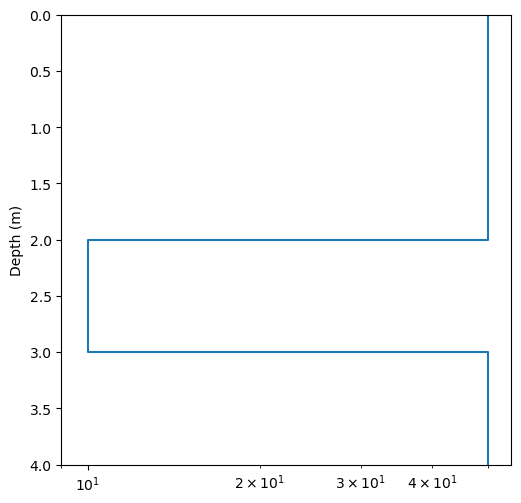

In [34]:
plot_1d_layer_model(thickness, rho)

In [35]:

import numpy as np
from simpeg import maps
import simpeg.electromagnetics.time_domain as tdem

source_height = 0.

# Source properties
source_location = np.array([0., 0., source_height])  
source_orientation = "z"                      # "x", "y" or "z"
source_current = 1.                           # maximum on-time current

# Receiver properties
receiver_location = np.array([0., 0., source_height+1.])
receiver_orientation = "z"                    # "x", "y" or "z"
# Receiver list
# Define receivers at each location.
receivers_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, "z",
    ),
]
waveform = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_lm, currents=input_currents_lm
)

# Must define the transmitter properties and associated receivers
source_list = [
    tdem.sources.CircularLoop(
        receivers_list,
        location=source_location,
        waveform=waveform,
        radius=radius
    ),
]

survey = tdem.Survey(source_list)
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=thickness, sigmaMap=maps.IdentityMap(nP=len(rho))
)
# %%time
dpred = simulation.dpred(1./rho)
dpred_background = simulation.dpred(1./rho_background)

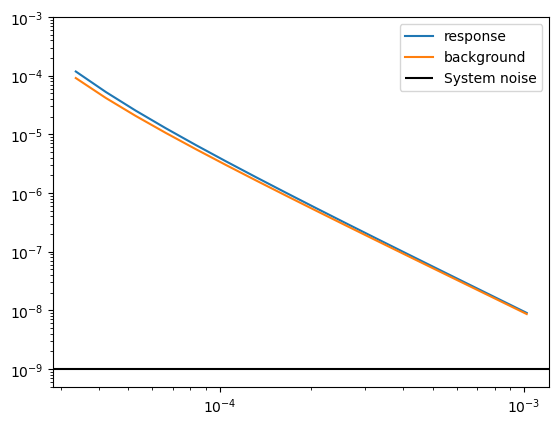

In [49]:
plt.loglog(times, -dpred, label='response')
plt.loglog(times, -dpred_background, label='background')
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.hlines(1e-9, xmin, xmax, color='k', label='System noise')
ax.set_ylim(5e-10, 1e-3)
plt.legend()